## Modelagem para Prevenção a Fraudes
<ul>
<li><b>Autor.:</b> Gabriel Nunes Henke</li>
<li><b>Programa:</b> PPGCC - Pós-Graduação em Ciência da Computação</li> 
<li><b>Disciplina:</b> Banco de Dados</li>
<li><b>Programa:</b> Ronaldo Correa</li>
<li><b>Data:</b> 08/06/2022</li>
</ul>


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1.0 Leitura do dataset

In [80]:
df = pd.read_csv("../data/dataset_online_fraud_detection.csv")
df = df.drop('Unnamed: 0', axis =1)

In [81]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
3,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
4,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06
mean,2.796394e+01,1.704465e+05,8.864969e+05,8.956942e+05,9.828208e+05,1.126970e+06,8.146096e-03,1.586966e-05
std,3.862915e+01,3.540274e+05,2.996935e+06,3.021933e+06,2.316250e+06,2.442277e+06,8.988740e-02,3.983645e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,1.288616e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+01,8.073570e+04,1.660104e+04,0.000000e+00,1.314209e+05,2.288872e+05,0.000000e+00,0.000000e+00
75%,3.800000e+01,2.187655e+05,1.461460e+05,1.766663e+05,9.207872e+05,1.167308e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000e+00,1.000000e+00


### 2.0 Análise e Exploração dos Dados

In [100]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06,1.008213e+06
mean,2.796394e+01,1.704465e+05,8.864969e+05,8.956942e+05,9.828208e+05,1.126970e+06,8.146096e-03,1.586966e-05
std,3.862915e+01,3.540274e+05,2.996935e+06,3.021933e+06,2.316250e+06,2.442277e+06,8.988740e-02,3.983645e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,1.288616e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+01,8.073570e+04,1.660104e+04,0.000000e+00,1.314209e+05,2.288872e+05,0.000000e+00,0.000000e+00
75%,3.800000e+01,2.187655e+05,1.461460e+05,1.766663e+05,9.207872e+05,1.167308e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,1.000000e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000e+00,1.000000e+00


In [82]:
df['type'].value_counts()

CASH_OUT    366632
PAYMENT     329867
CASH_IN     218938
TRANSFER     86301
DEBIT         6475
Name: type, dtype: int64

In [83]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [84]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

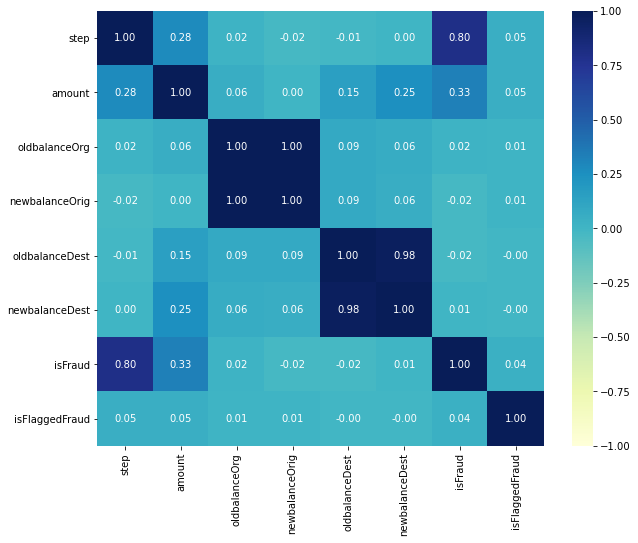

In [85]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

In [86]:
df.isFraud.value_counts().index

Int64Index([0, 1], dtype='int64')

In [132]:
pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1]

type
CASH_IN        NaN
CASH_OUT    4116.0
DEBIT          NaN
PAYMENT        NaN
TRANSFER    4097.0
Name: 1, dtype: float64

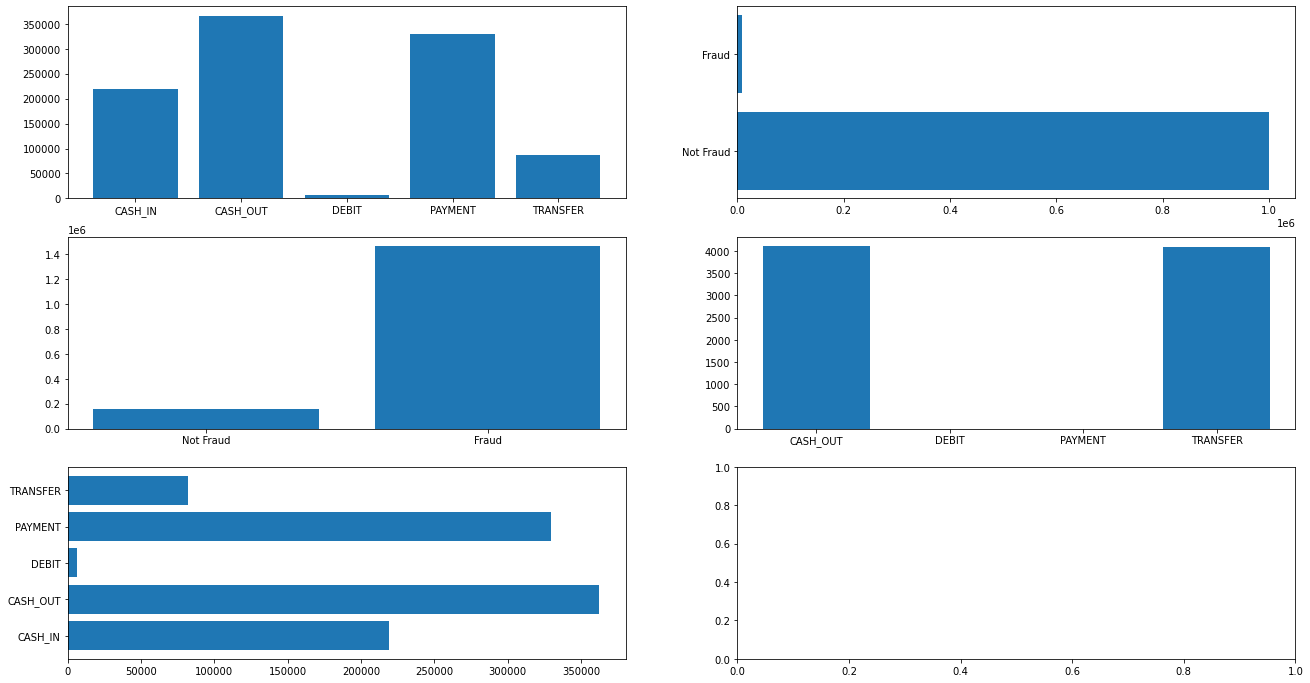

In [136]:
fig, axes = plt.subplots(3, 2, figsize=(22, 12))
ax1 = axes[0, 0].bar(df.groupby(by="type").count()['isFraud'].index, df.groupby(by="type").count()['isFraud'])
ax2 = axes[0, 1].barh(["Not Fraud", "Fraud"], df.isFraud.value_counts())
ax3 = axes[1, 0].bar(["Not Fraud", "Fraud"], df.drop('isFlaggedFraud', axis =1).groupby(by="isFraud").mean()['amount'].round())
ax4 = axes[1, 1].bar(pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1].index, pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][1])
ax5 = axes[2, 0].barh(pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][0].index, pd.pivot_table(df, index = 'type',columns = 'isFraud',aggfunc ='count')["amount"][0])
# ax4 = axes[2, 1].bar(df['Kidhome'].value_counts().index, df['Kidhome'].value_counts())

In [ ]:
df['isFraud'].value_counts()

array([[<AxesSubplot:title={'center':'step'}>,
        <AxesSubplot:title={'center':'amount'}>,
        <AxesSubplot:title={'center':'oldbalanceOrg'}>],
       [<AxesSubplot:title={'center':'newbalanceOrig'}>,
        <AxesSubplot:title={'center':'oldbalanceDest'}>,
        <AxesSubplot:title={'center':'newbalanceDest'}>],
       [<AxesSubplot:title={'center':'isFraud'}>,
        <AxesSubplot:title={'center':'isFlaggedFraud'}>, <AxesSubplot:>]],
      dtype=object)

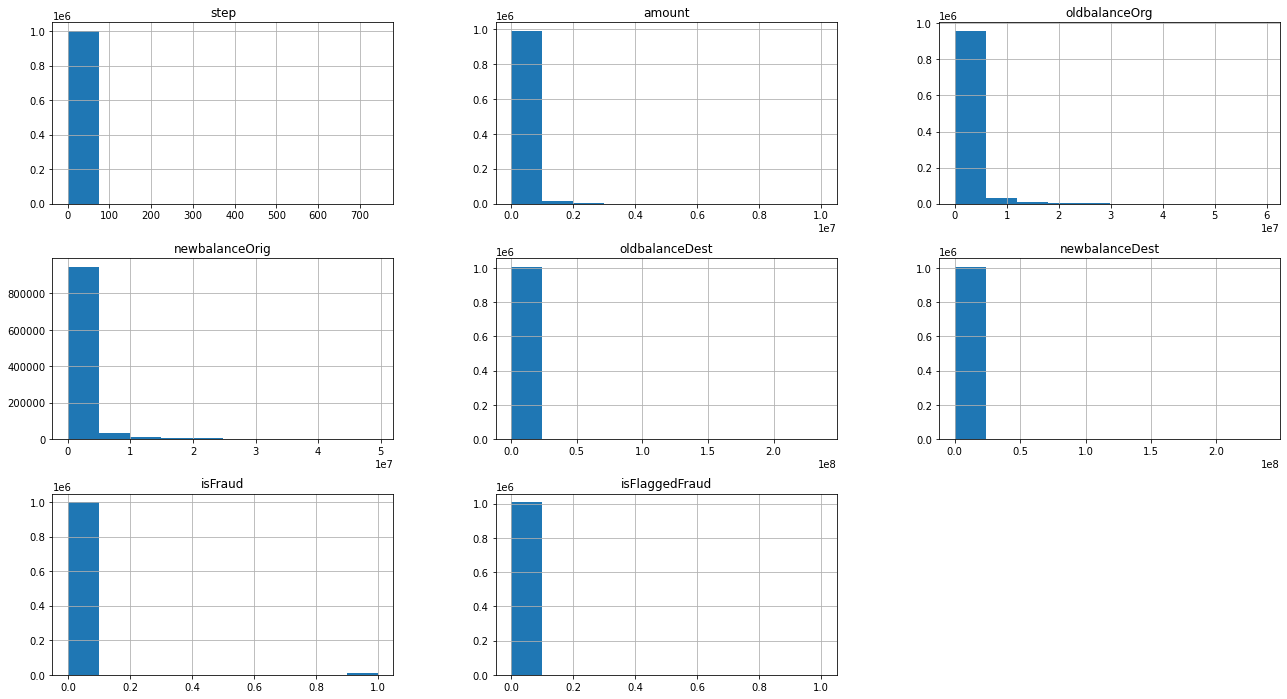

In [135]:
df.round().hist(figsize=(22,12))

### 3.0 Tratamento dos Dados (Pré Processamento)

#### 3.1 Tratamento de Outliers

In [137]:
### 4.0 Feature Engineering

In [ ]:
### 5.0 Seleçao de Atributos

In [12]:
### 6.0 Treinamento do modelo preditivo

In [13]:
### 7.0 Validação e avaliação do modelo

In [ ]:
### 8.0 Exportação do modelo